# Investigate CESM1-LE ensemble average behavior

### Forced response here

Potentially look at the trends in order to estimate the standard deviation (areas of high/low internal variability).  

Remember that I corrected the CESM time labelling offset before taking the ensemble average, so I don't need to do that here.

### Use trendified data as well

Can calculate the standard deviation of trends across different ensemble members

### Do imports

In [1]:
import sys
# Add common resources folder to path
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/spectral_ice/')
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/spectral_ice/Common/') # is this good or not good. I should reorg.
# sys.path.append("/home/jonahks/git_repos/netcdf_analysis/Common/")

from imports import (
    pd, np, xr, mpl, plt, sns, os, 
    datetime, gridspec, ccrs, 
    Iterable, cmaps, glob
    )

from functions import (
    masked_average, add_weights, leap_year,
    to_png, stats, MidpointNormalize, fix_cesm_time
    )

from collections import deque
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Define function for computing trends

#### New slower function that uses scipy.stats.linregress via apply_ufunc and gets info on statistical significance

In [2]:
def arc_subset(*paths,var):
    '''
    Takes paths to several GCM outputs that are adjacent in time. Concatentates files and then 
    - subsets for time period 2001-2020.
    - subsets for the Arctic (lat > 60N)
    
    return subsetted data
    '''

    _ds_i = xr.open_mfdataset(paths)
    subset = _ds_i[var].sel(time=slice('2001-01-01','2020-12-31'),lat=slice(59,None))
    _ds_i.close()
    
    return subset

In [3]:
def linregress2(x, y):
    # Wrapper around scipy linregress to use in apply_ufunc
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    return np.array([slope, intercept, r_value, p_value, std_err])

In [4]:
def vectorized_linregress2(data):
    '''
    Package for vectorized linregress call from: 
    https://stackoverflow.com/questions/52094320/with-xarray-how-to-parallelize-1d-operations-on-a-multidimensional-dataset. 
    Not very general.
    '''
    
    regressed_month = xr.apply_ufunc(
        linregress2, data['year'], data,
        input_core_dims=[['year'], ['year']],
        output_core_dims=[["parameter"]],
        vectorize=True,
        dask="parallelized",
        output_dtypes=['float64'],
        output_sizes={"parameter": 5},
                      )
    
    return regressed_month

In [5]:
def compute_trends_n_signif2(subset_data):
    '''
    Package the trend calculating lines to save space. V2 uses vectorized_linregress2
    '''
    # create empty arrays for needed output
    _trends = xr.zeros_like(subset_data.groupby('time.month').mean('time')).load()
    _rvalues = _trends.copy()
    _pvalues = _trends.copy()

    # Potentially I should be able to format this to avoid this for loop too
    for i,_month in subset_data.groupby('time.month'):
#         print(i,end='')

        _yearlydata = _month.groupby('time.year').mean('time').chunk({'year': -1}) # let the other dimensions chunk however?
        regressed_month = vectorized_linregress2(_yearlydata)

        ii = i-1 # the count starts at month 1 (January) but we need to index starting at 0
        
        _trends[ii] = regressed_month.isel(parameter=0)
        _rvalues[ii] = regressed_month.isel(parameter=2)
        _pvalues[ii] = regressed_month.isel(parameter=3)

    # Calculate statistical significance
    N = len(_yearlydata.year)
    dof=N-2

    tcrit=stats.t.ppf(0.975,dof)  ## two-sided 95%
    t=_rvalues*np.sqrt(N-2)/np.sqrt((1-_rvalues*_rvalues))

    _statsig=(1-_pvalues)*100
    _notnull = t > tcrit # disproving the null hypothesis (slope is zero)    
    
    return _trends,_statsig,_notnull

In [6]:
def compute_trend(ds:xr.DataArray,mask=None):
    '''
    Takes an xarray object (dataset or dataarray?), variable name, path to save to, and mask. 
    Computes time trends over the mon-lat grid, as well as the statistical significance of those trends and saves them.
    '''
    
    _lon_avg = masked_average(ds,mask=mask,dim=['lon'])

    _trends,_statsig,_notnull = compute_trends_n_signif2(_lon_avg)    
    
    all_data = xr.merge([_trends.rename('TREND'),_statsig.rename('STATSIG'),_notnull.rename('NOTNULL')])
    
    return all_data

### Format and select ensemble average data

In [7]:
ensavg_path = '/glade/work/jonahshaw/LENS/CESM1-LE/EnsAvg/'

In [9]:
var_list = ['TS','SOLIN','FSNTOA','FLUT','ICEFRAC','TMQ']

In [10]:
proc_dict = {} # dictionary for processed data

for i in var_list:
    print(i)
    _files = glob.glob('%s/*%s*.nc' % (ensavg_path,i)) # get appropriate files    
    _subset = arc_subset(_files,var=i) # subset in time and space
    
    proc_dict[i] = compute_trend(_subset) # compute trend, etc and store in proc_dict
#     break

TS
SOLIN
FSNTOA
FLUT
ICEFRAC
TMQ


## Plot with variable ranges for most extreme ensemble members

Text(0.5, 0.95, 'Trends in CESM1-LE Ensemble Average')

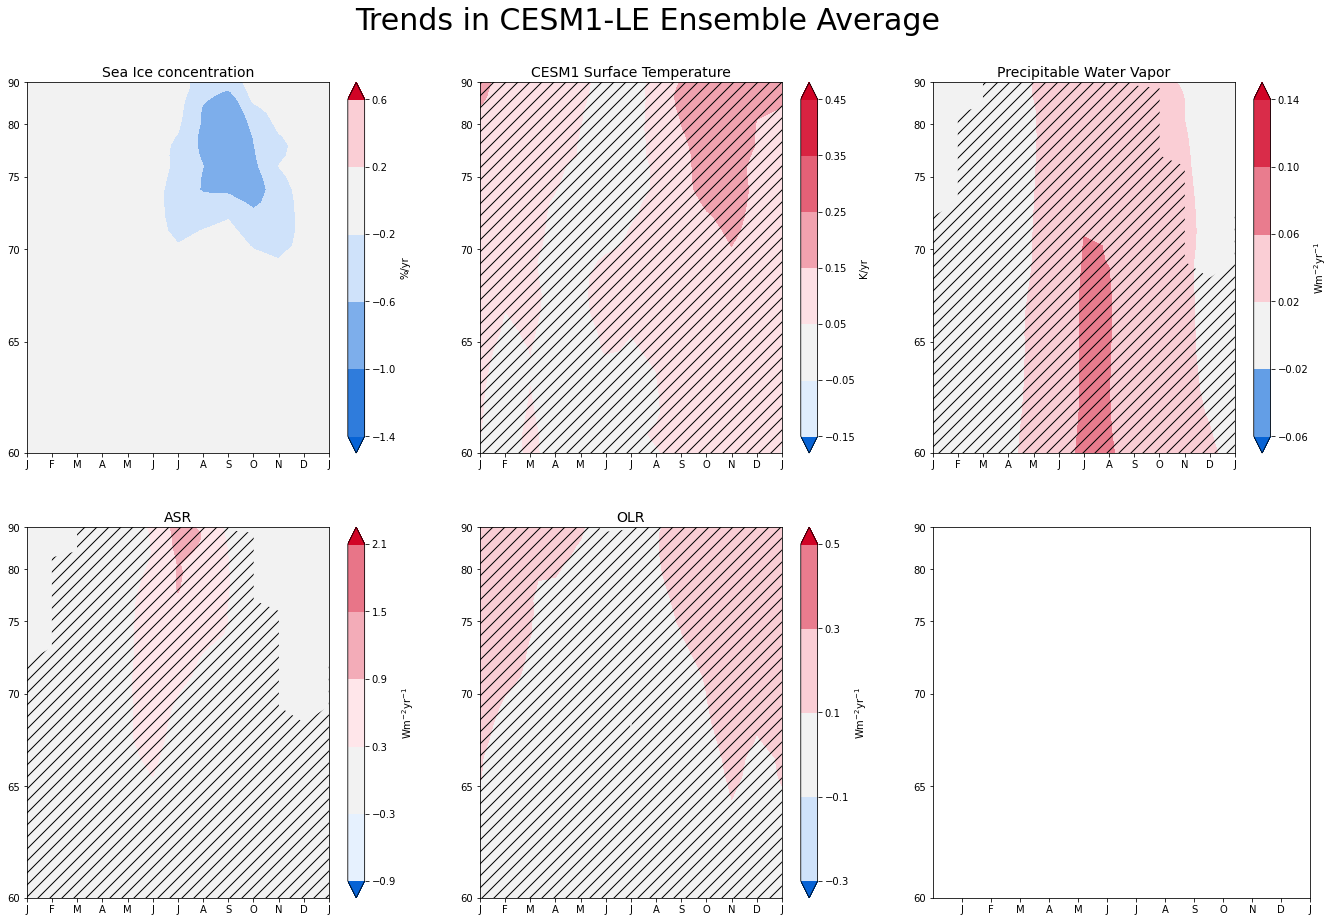

In [14]:
_olr = proc_dict['FLUT']
_asr = proc_dict['FSNTOA']
_icefrac = 100*proc_dict['ICEFRAC']
_ts = proc_dict['TS']
_tmq = proc_dict['TMQ']

ts_trends_wrapped = xr.concat([_ts['TREND'],_ts['TREND'][0].assign_coords({'month':13})],dim='month')
ts_statsig_wrapped = xr.concat([_ts['STATSIG'],_ts['STATSIG'][0].assign_coords({'month':13})],dim='month')

seaice_trends_wrapped = xr.concat([_icefrac['TREND'],_icefrac['TREND'][0].assign_coords({'month':13})],dim='month')
seaice_statsig_wrapped = xr.concat([_icefrac['STATSIG'],_icefrac['STATSIG'][0].assign_coords({'month':13})],dim='month')

asr_trends_wrapped = xr.concat([_asr['TREND'],_asr['TREND'][0].assign_coords({'month':13})],dim='month')
asr_statsig_wrapped = xr.concat([_asr['STATSIG'],_asr['STATSIG'][0].assign_coords({'month':13})],dim='month')

olr_trends_wrapped = xr.concat([_olr['TREND'],_olr['TREND'][0].assign_coords({'month':13})],dim='month')
olr_statsig_wrapped = xr.concat([_olr['STATSIG'],_olr['STATSIG'][0].assign_coords({'month':13})],dim='month')

tmq_trends_wrapped = xr.concat([_tmq['TREND'],_tmq['TREND'][0].assign_coords({'month':13})],dim='month')
tmq_statsig_wrapped = xr.concat([_tmq['STATSIG'],_tmq['STATSIG'][0].assign_coords({'month':13})],dim='month')

fig1,axs = plt.subplots(nrows=2,ncols=3,figsize=(23,15))

axes = axs.flat

ytick_labels = np.array([60,65,70,75,80,90])
yticks = np.sin(np.pi*ytick_labels/180)

xtick_labels = ['J','F','M','A','M','J','J','A','S','O','N','D','J']
xticks = np.arange(1,13.01,1)

palette = sns.diverging_palette(257, 10, s=99, l=44, sep=50, n=8, as_cmap=True)

# Set axis ticks accounting for area weighting
for _ax in axes:
    _ax.set_ylim(np.sin(np.pi/3),1)
    _ax.set_yticks(yticks)
    _ax.set_yticklabels(ytick_labels)
    _ax.set_xticks(xticks)
    _ax.set_xticklabels(xtick_labels)

lat_weighted0 = np.sin(np.pi/180*seaice_trends_wrapped['lat'])
im0 = axes[0].contourf(seaice_trends_wrapped['month'],lat_weighted0,seaice_trends_wrapped.transpose('lat','month'), # -1.4,0.4
                       cmap=palette,norm=mpl.colors.TwoSlopeNorm(vmin=-1.4, vcenter=0., vmax=1.4),levels=np.arange(-1.4,0.61,0.4),extend='both')
stip = axes[0].contourf(seaice_statsig_wrapped['month'],lat_weighted0,seaice_statsig_wrapped.transpose('lat','month'), colors='none',levels=[0,99,100],
                        hatches=[None,'//'],extend='neither')
axes[0].set_title('Sea Ice concentration',fontsize=14)
plt.colorbar(im0,ax=axes[0],label='%/yr')

lat_weighted1 = np.sin(np.pi/180*ts_trends_wrapped['lat'])
im1 = axes[1].contourf(ts_trends_wrapped['month'],lat_weighted1,ts_trends_wrapped.transpose('lat','month'), # -0.15,0.45
                       cmap=palette,norm=mpl.colors.TwoSlopeNorm(vmin=-0.45, vcenter=0., vmax=0.45),levels=np.arange(-0.15,0.451,0.1),extend='both')
stip = axes[1].contourf(ts_statsig_wrapped['month'],lat_weighted1,ts_statsig_wrapped.transpose('lat','month'), colors='none',levels=[0,99,100],
                        hatches=[None,'//'],extend='neither')
axes[1].set_title('CESM1 Surface Temperature',fontsize=14)
cbar = plt.colorbar(im1,ax=axes[1],label='K/yr')

lat_weighted2 = np.sin(np.pi/180*tmq_trends_wrapped['lat'])
im2 = axes[2].contourf(tmq_trends_wrapped['month'],lat_weighted2,tmq_trends_wrapped.transpose('lat','month'), # -0.6,3.0
                       cmap=palette,norm=mpl.colors.TwoSlopeNorm(vmin=-0.06, vcenter=0., vmax=0.14),extend='both',levels=np.arange(-0.06,0.141,0.04))
stip = axes[2].contourf(asr_statsig_wrapped['month'],lat_weighted2,asr_statsig_wrapped.transpose('lat','month'), colors='none',levels=[0,99,100],
                        hatches=[None,'//'],extend='neither')
axes[2].set_title('Precipitable Water Vapor',fontsize=14)
plt.colorbar(im2,ax=axes[2],label='Wm$^{-2}$yr$^{-1}$')

# lat_weighted2 = np.sin(np.pi/180*asr_trends_wrapped['lat'])
# im2 = axes[2].contourf(asr_trends_wrapped['month'],lat_weighted2,asr_trends_wrapped.transpose('lat','month'), # -0.6,3.0
#                        cmap=palette,norm=mpl.colors.TwoSlopeNorm(vmin=-3.0, vcenter=0., vmax=3.01),levels=np.arange(-0.9,2.11,0.6),extend='both')
# stip = axes[2].contourf(asr_statsig_wrapped['month'],lat_weighted2,asr_statsig_wrapped.transpose('lat','month'), colors='none',levels=[0,99,100],
#                         hatches=[None,'//'],extend='neither')
# axes[2].set_title('CERES ASR Trend',fontsize=14)
# plt.colorbar(im2,ax=axes[2],label='Wm$^{-2}$yr$^{-1}$')

lat_weighted3 = np.sin(np.pi/180*asr_trends_wrapped['lat'])
im3 = axes[3].contourf(asr_trends_wrapped['month'],lat_weighted3,asr_trends_wrapped.transpose('lat','month'), # -0.3,0.7
                       cmap=palette,norm=mpl.colors.TwoSlopeNorm(vmin=-3.0, vcenter=0., vmax=3.01),levels=np.arange(-0.9,2.11,0.6),extend='both')
stip = axes[3].contourf(asr_statsig_wrapped['month'],lat_weighted3,asr_statsig_wrapped.transpose('lat','month'), colors='none',levels=[0,99,100],
                        hatches=[None,'//'],extend='neither')
axes[3].set_title('ASR',fontsize=14)
plt.colorbar(im3,ax=axes[3],label='Wm$^{-2}$yr$^{-1}$')

lat_weighted4 = np.sin(np.pi/180*olr_trends_wrapped['lat'])
im4 = axes[4].contourf(olr_trends_wrapped['month'],lat_weighted4,olr_trends_wrapped.transpose('lat','month'), # -0.3,0.7
                       cmap=palette,norm=mpl.colors.TwoSlopeNorm(vmin=-0.7, vcenter=0., vmax=0.7),levels=np.arange(-0.3,0.7,0.2),extend='both')
stip = axes[4].contourf(olr_statsig_wrapped['month'],lat_weighted4,olr_statsig_wrapped.transpose('lat','month'), colors='none',levels=[0,99,100],
                        hatches=[None,'//'],extend='neither')
axes[4].set_title('OLR',fontsize=14)
plt.colorbar(im4,ax=axes[4],label='Wm$^{-2}$yr$^{-1}$')

fig1.suptitle('Trends in CESM1-LE Ensemble Average',fontsize=30,y=0.95)

## Plot with variable ranges for forced response (more detailed)

Text(0.5, 0.95, 'Trends in CESM1-LE Ensemble Average')

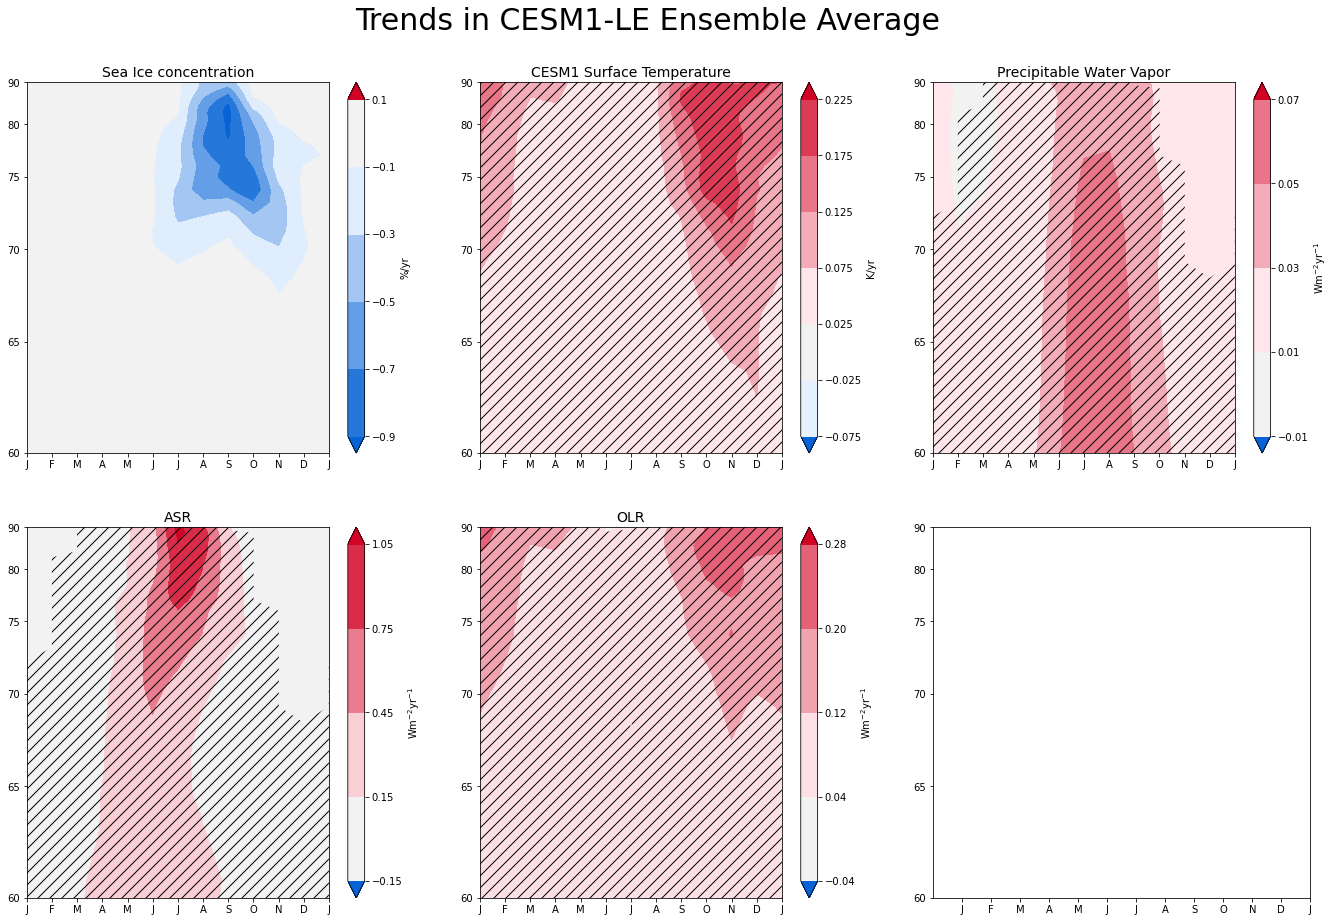

In [22]:
_olr = proc_dict['FLUT']
_asr = proc_dict['FSNTOA']
_icefrac = 100*proc_dict['ICEFRAC']
_ts = proc_dict['TS']
_tmq = proc_dict['TMQ']

ts_trends_wrapped = xr.concat([_ts['TREND'],_ts['TREND'][0].assign_coords({'month':13})],dim='month')
ts_statsig_wrapped = xr.concat([_ts['STATSIG'],_ts['STATSIG'][0].assign_coords({'month':13})],dim='month')

seaice_trends_wrapped = xr.concat([_icefrac['TREND'],_icefrac['TREND'][0].assign_coords({'month':13})],dim='month')
seaice_statsig_wrapped = xr.concat([_icefrac['STATSIG'],_icefrac['STATSIG'][0].assign_coords({'month':13})],dim='month')

asr_trends_wrapped = xr.concat([_asr['TREND'],_asr['TREND'][0].assign_coords({'month':13})],dim='month')
asr_statsig_wrapped = xr.concat([_asr['STATSIG'],_asr['STATSIG'][0].assign_coords({'month':13})],dim='month')

olr_trends_wrapped = xr.concat([_olr['TREND'],_olr['TREND'][0].assign_coords({'month':13})],dim='month')
olr_statsig_wrapped = xr.concat([_olr['STATSIG'],_olr['STATSIG'][0].assign_coords({'month':13})],dim='month')

tmq_trends_wrapped = xr.concat([_tmq['TREND'],_tmq['TREND'][0].assign_coords({'month':13})],dim='month')
tmq_statsig_wrapped = xr.concat([_tmq['STATSIG'],_tmq['STATSIG'][0].assign_coords({'month':13})],dim='month')

fig1,axs = plt.subplots(nrows=2,ncols=3,figsize=(23,15))

axes = axs.flat

ytick_labels = np.array([60,65,70,75,80,90])
yticks = np.sin(np.pi*ytick_labels/180)

xtick_labels = ['J','F','M','A','M','J','J','A','S','O','N','D','J']
xticks = np.arange(1,13.01,1)

palette = sns.diverging_palette(257, 10, s=99, l=44, sep=50, n=8, as_cmap=True)

# Set axis ticks accounting for area weighting
for _ax in axes:
    _ax.set_ylim(np.sin(np.pi/3),1)
    _ax.set_yticks(yticks)
    _ax.set_yticklabels(ytick_labels)
    _ax.set_xticks(xticks)
    _ax.set_xticklabels(xtick_labels)

lat_weighted0 = np.sin(np.pi/180*seaice_trends_wrapped['lat'])
im0 = axes[0].contourf(seaice_trends_wrapped['month'],lat_weighted0,seaice_trends_wrapped.transpose('lat','month'), # -1.4,0.4
                       cmap=palette,norm=mpl.colors.TwoSlopeNorm(vmin=-0.9, vcenter=0., vmax=0.9),levels=np.arange(-0.9,0.11,0.2),extend='both')
stip = axes[0].contourf(seaice_statsig_wrapped['month'],lat_weighted0,seaice_statsig_wrapped.transpose('lat','month'), colors='none',levels=[0,99,100],
                        hatches=[None,'//'],extend='neither')
axes[0].set_title('Sea Ice concentration',fontsize=14)
plt.colorbar(im0,ax=axes[0],label='%/yr')

lat_weighted1 = np.sin(np.pi/180*ts_trends_wrapped['lat'])
im1 = axes[1].contourf(ts_trends_wrapped['month'],lat_weighted1,ts_trends_wrapped.transpose('lat','month'), # -0.15,0.45
                       cmap=palette,norm=mpl.colors.TwoSlopeNorm(vmin=-0.25, vcenter=0., vmax=0.25),levels=np.arange(-0.075,0.2251,0.05),extend='both')
stip = axes[1].contourf(ts_statsig_wrapped['month'],lat_weighted1,ts_statsig_wrapped.transpose('lat','month'), colors='none',levels=[0,99,100],
                        hatches=[None,'//'],extend='neither')
axes[1].set_title('CESM1 Surface Temperature',fontsize=14)
cbar = plt.colorbar(im1,ax=axes[1],label='K/yr')

lat_weighted2 = np.sin(np.pi/180*tmq_trends_wrapped['lat'])
im2 = axes[2].contourf(tmq_trends_wrapped['month'],lat_weighted2,tmq_trends_wrapped.transpose('lat','month'), # -0.6,3.0
                       cmap=palette,norm=mpl.colors.TwoSlopeNorm(vmin=-0.1, vcenter=0., vmax=0.10),extend='both',levels=np.arange(-0.01,0.09,0.02))
stip = axes[2].contourf(asr_statsig_wrapped['month'],lat_weighted2,asr_statsig_wrapped.transpose('lat','month'), colors='none',levels=[0,99,100],
                        hatches=[None,'//'],extend='neither')
axes[2].set_title('Precipitable Water Vapor',fontsize=14)
plt.colorbar(im2,ax=axes[2],label='Wm$^{-2}$yr$^{-1}$')

lat_weighted3 = np.sin(np.pi/180*asr_trends_wrapped['lat'])
im3 = axes[3].contourf(asr_trends_wrapped['month'],lat_weighted3,asr_trends_wrapped.transpose('lat','month'), # -0.3,0.7
                       cmap=palette,norm=mpl.colors.TwoSlopeNorm(vmin=-1.05, vcenter=0., vmax=1.05),levels=np.arange(-0.15,1.06,0.30),extend='both')
stip = axes[3].contourf(asr_statsig_wrapped['month'],lat_weighted3,asr_statsig_wrapped.transpose('lat','month'), colors='none',levels=[0,99,100],
                        hatches=[None,'//'],extend='neither')
axes[3].set_title('ASR',fontsize=14)
plt.colorbar(im3,ax=axes[3],label='Wm$^{-2}$yr$^{-1}$')

lat_weighted4 = np.sin(np.pi/180*olr_trends_wrapped['lat'])
im4 = axes[4].contourf(olr_trends_wrapped['month'],lat_weighted4,olr_trends_wrapped.transpose('lat','month'), # -0.3,0.7
                       cmap=palette,norm=mpl.colors.TwoSlopeNorm(vmin=-0.36, vcenter=0., vmax=0.36),levels=np.arange(-0.04,0.36,0.08),extend='both')
stip = axes[4].contourf(olr_statsig_wrapped['month'],lat_weighted4,olr_statsig_wrapped.transpose('lat','month'), colors='none',levels=[0,99,100],
                        hatches=[None,'//'],extend='neither')
axes[4].set_title('OLR',fontsize=14)
plt.colorbar(im4,ax=axes[4],label='Wm$^{-2}$yr$^{-1}$')

fig1.suptitle('Trends in CESM1-LE Ensemble Average',fontsize=30,y=0.95)

## Stack ensemble trends

Will need to add an extra coordinates and then use an xr.merge or similar command

In [75]:
memberavg_path = '/glade/work/jonahshaw/LENS/CESM1-LE/ArcticMemberTrends/'

In [76]:
model_variables = ['ICEFRAC','FLUT','FSNTOA','TS','LANDFRAC']

In [77]:
# hardcoded alternate with only ensembles we can use
ensemble_nums2 = [
    '001', '002', '003', '004', '005', 
    '006', '007', '008', '009', '010',
    '011', '012', '013', '014', '015',
    '016', '017', '018', '019', '020',
    '021', '022', '023', '024', '025', 
    '026', '027', '028', '029', '030', 
    '031', '032', '033', '034', '035', 
    '101', '102', '103', '104', '105'
]

#### Need to add another dimension in order to stack them.

In [162]:
multiens_dict = {}

for _var in model_variables:
    
    all_ens = [] # list to combine later
    
    for _ensn in ensemble_nums2:            
        _file = glob.glob('%s/*%s.%s*.nc' % (memberavg_path,_var,_ensn))[0]
        _ds = xr.open_dataset(_file)
        
        _ds2 = _ds.assign_coords({'ensn':int(_ensn)}).expand_dims('ensn')
        _ds.close()
        
        if _ensn == '001': # handle a weird combining error by interpolating Toronto runs to standard grid
            _interptarget = _ds
        
        # add
        if _ensn in ['101','102','103','104','105',]: 
            _ds2 = _ds2.interp_like(_interptarget)
        
        all_ens.append(_ds2)
        
    multiens_dict[_var] = xr.combine_by_coords(all_ens)
    
#     break

#### Plot aggregated trends for sanity

Text(0.5, 0.95, 'Trends in CESM1-LE Ensemble Average (from individual trends)')

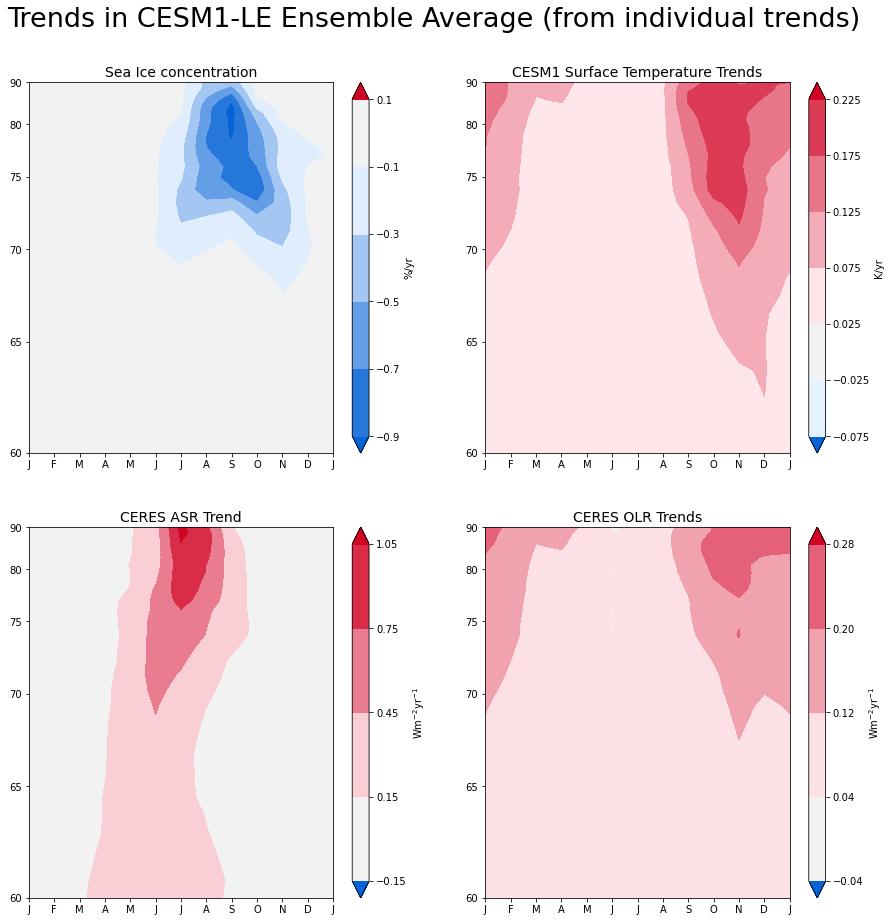

In [177]:
_olr2 = multiens_dict['FLUT'].mean(dim='ensn')
_asr2 = multiens_dict['FSNTOA'].mean(dim='ensn')
_icefrac2 = multiens_dict['ICEFRAC'].mean(dim='ensn')
_ts2 = multiens_dict['TS'].mean(dim='ensn')

ts_trends_wrapped = xr.concat([_ts2['TREND'],_ts2['TREND'][0].assign_coords({'month':13})],dim='month')
# ts_statsig_wrapped = xr.concat([_ts2['STATSIG'],_ts2['STATSIG'][0].assign_coords({'month':13})],dim='month')

seaice_trends_wrapped = xr.concat([_icefrac2['TREND'],_icefrac2['TREND'][0].assign_coords({'month':13})],dim='month')
# seaice_statsig_wrapped = xr.concat([_icefrac2['STATSIG'],_icefrac2['STATSIG'][0].assign_coords({'month':13})],dim='month')

asr_trends_wrapped = xr.concat([_asr2['TREND'],_asr2['TREND'][0].assign_coords({'month':13})],dim='month')
# asr_statsig_wrapped = xr.concat([_asr2['STATSIG'],_asr2['STATSIG'][0].assign_coords({'month':13})],dim='month')

olr_trends_wrapped = xr.concat([_olr2['TREND'],_olr2['TREND'][0].assign_coords({'month':13})],dim='month')
# olr_statsig_wrapped = xr.concat([_olr2['STATSIG'],_olr2['STATSIG'][0].assign_coords({'month':13})],dim='month')

fig1,axs = plt.subplots(nrows=2,ncols=2,figsize=(15,15))

axes = axs.flat

ytick_labels = np.array([60,65,70,75,80,90])
yticks = np.sin(np.pi*ytick_labels/180)

xtick_labels = ['J','F','M','A','M','J','J','A','S','O','N','D','J']
xticks = np.arange(1,13.01,1)

palette = sns.diverging_palette(257, 10, s=99, l=44, sep=50, n=8, as_cmap=True)

# Set axis ticks accounting for area weighting
for _ax in axes:
    _ax.set_ylim(np.sin(np.pi/3),1)
    _ax.set_yticks(yticks)
    _ax.set_yticklabels(ytick_labels)
    _ax.set_xticks(xticks)
    _ax.set_xticklabels(xtick_labels)

lat_weighted0 = np.sin(np.pi/180*seaice_trends_wrapped['lat'])
im0 = axes[0].contourf(seaice_trends_wrapped['month'],lat_weighted0,seaice_trends_wrapped.transpose('lat','month'), # -1.4,0.4
                       cmap=palette,norm=mpl.colors.TwoSlopeNorm(vmin=-0.9, vcenter=0., vmax=0.9),levels=np.arange(-0.9,0.11,0.2),extend='both')
# stip = axes[0].contourf(seaice_statsig_wrapped['month'],lat_weighted0,seaice_statsig_wrapped.transpose('lat','month'), colors='none',levels=[0,99,100],
#                         hatches=[None,'//'],extend='neither')
axes[0].set_title('Sea Ice concentration',fontsize=14)
plt.colorbar(im0,ax=axes[0],label='%/yr')

lat_weighted1 = np.sin(np.pi/180*ts_trends_wrapped['lat'])
im1 = axes[1].contourf(ts_trends_wrapped['month'],lat_weighted1,ts_trends_wrapped.transpose('lat','month'), # -0.15,0.45
                       cmap=palette,norm=mpl.colors.TwoSlopeNorm(vmin=-0.25, vcenter=0., vmax=0.25),levels=np.arange(-0.075,0.2251,0.05),extend='both')
# stip = axes[1].contourf(ts_statsig_wrapped['month'],lat_weighted1,ts_statsig_wrapped.transpose('lat','month'), colors='none',levels=[0,99,100],
#                         hatches=[None,'//'],extend='neither')
axes[1].set_title('CESM1 Surface Temperature Trends',fontsize=14)
cbar = plt.colorbar(im1,ax=axes[1],label='K/yr')

lat_weighted2 = np.sin(np.pi/180*asr_trends_wrapped['lat'])
im2 = axes[2].contourf(asr_trends_wrapped['month'],lat_weighted2,asr_trends_wrapped.transpose('lat','month'), # -0.6,3.0
                       cmap=palette,norm=mpl.colors.TwoSlopeNorm(vmin=-1.05, vcenter=0., vmax=1.05),levels=np.arange(-0.15,1.06,0.30),extend='both')
# stip = axes[2].contourf(asr_statsig_wrapped['month'],lat_weighted2,asr_statsig_wrapped.transpose('lat','month'), colors='none',levels=[0,99,100],
#                         hatches=[None,'//'],extend='neither')
axes[2].set_title('CERES ASR Trend',fontsize=14)
plt.colorbar(im2,ax=axes[2],label='Wm$^{-2}$yr$^{-1}$')

lat_weighted3 = np.sin(np.pi/180*olr_trends_wrapped['lat'])
im3 = axes[3].contourf(olr_trends_wrapped['month'],lat_weighted3,olr_trends_wrapped.transpose('lat','month'), # -0.3,0.7
                       cmap=palette,norm=mpl.colors.TwoSlopeNorm(vmin=-0.36, vcenter=0., vmax=0.36),levels=np.arange(-0.04,0.36,0.08),extend='both')
# stip = axes[3].contourf(olr_statsig_wrapped['month'],lat_weighted3,olr_statsig_wrapped.transpose('lat','month'), colors='none',levels=[0,99,100],
#                         hatches=[None,'//'],extend='neither')
axes[3].set_title('CERES OLR Trends',fontsize=14)
plt.colorbar(im3,ax=axes[3],label='Wm$^{-2}$yr$^{-1}$')

fig1.suptitle('Trends in CESM1-LE Ensemble Average (from individual trends)',fontsize=27,y=0.95)

Text(0.5, 0.95, 'Trends in CESM1-LE Ensemble Average (from individual trends)')

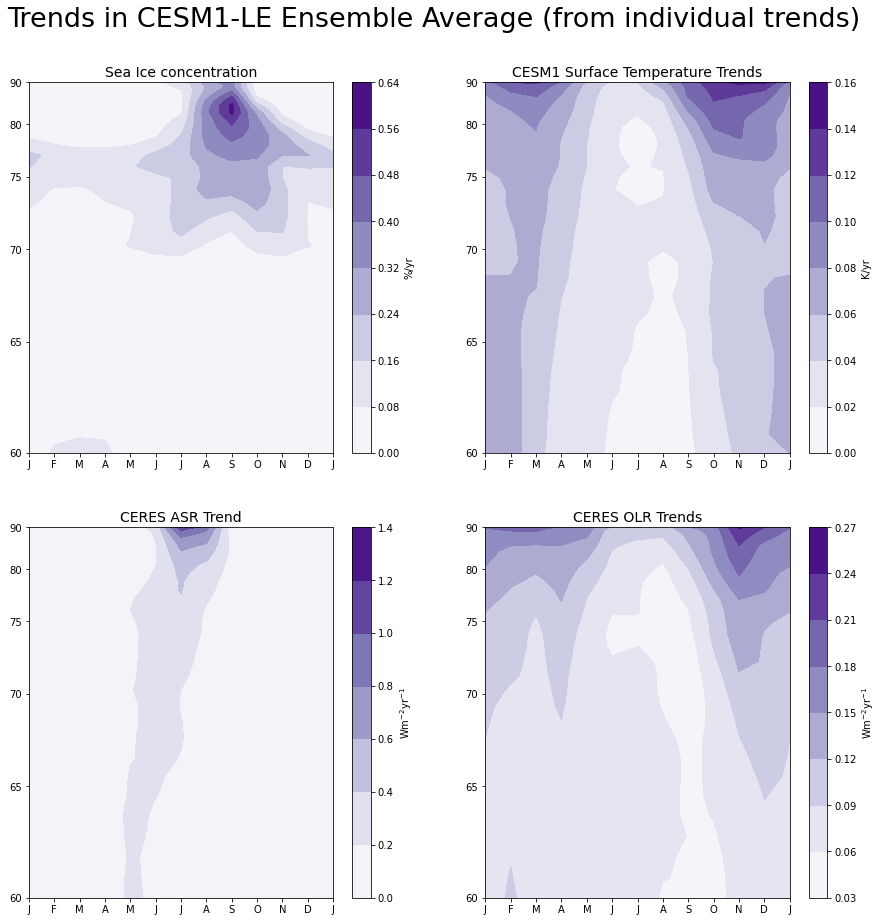

In [186]:
_olr2 = multiens_dict['FLUT'].std(dim='ensn')
_asr2 = multiens_dict['FSNTOA'].std(dim='ensn')
_icefrac2 = multiens_dict['ICEFRAC'].std(dim='ensn')
_ts2 = multiens_dict['TS'].std(dim='ensn')

ts_trends_wrapped = xr.concat([_ts2['TREND'],_ts2['TREND'][0].assign_coords({'month':13})],dim='month')
# ts_statsig_wrapped = xr.concat([_ts2['STATSIG'],_ts2['STATSIG'][0].assign_coords({'month':13})],dim='month')

seaice_trends_wrapped = xr.concat([_icefrac2['TREND'],_icefrac2['TREND'][0].assign_coords({'month':13})],dim='month')
# seaice_statsig_wrapped = xr.concat([_icefrac2['STATSIG'],_icefrac2['STATSIG'][0].assign_coords({'month':13})],dim='month')

asr_trends_wrapped = xr.concat([_asr2['TREND'],_asr2['TREND'][0].assign_coords({'month':13})],dim='month')
# asr_statsig_wrapped = xr.concat([_asr2['STATSIG'],_asr2['STATSIG'][0].assign_coords({'month':13})],dim='month')

olr_trends_wrapped = xr.concat([_olr2['TREND'],_olr2['TREND'][0].assign_coords({'month':13})],dim='month')
# olr_statsig_wrapped = xr.concat([_olr2['STATSIG'],_olr2['STATSIG'][0].assign_coords({'month':13})],dim='month')

fig1,axs = plt.subplots(nrows=2,ncols=2,figsize=(15,15))

axes = axs.flat

ytick_labels = np.array([60,65,70,75,80,90])
yticks = np.sin(np.pi*ytick_labels/180)

xtick_labels = ['J','F','M','A','M','J','J','A','S','O','N','D','J']
xticks = np.arange(1,13.01,1)

palette = sns.diverging_palette(257, 10, s=99, l=44, sep=50, n=8, as_cmap=True)

# Set axis ticks accounting for area weighting
for _ax in axes:
    _ax.set_ylim(np.sin(np.pi/3),1)
    _ax.set_yticks(yticks)
    _ax.set_yticklabels(ytick_labels)
    _ax.set_xticks(xticks)
    _ax.set_xticklabels(xtick_labels)

lat_weighted0 = np.sin(np.pi/180*seaice_trends_wrapped['lat'])
im0 = axes[0].contourf(seaice_trends_wrapped['month'],lat_weighted0,seaice_trends_wrapped.transpose('lat','month'), # -1.4,0.4
                       cmap='Purples')#,norm=mpl.colors.TwoSlopeNorm(vmin=-0.9, vcenter=0., vmax=0.9),levels=np.arange(-0.9,0.11,0.2),extend='both')
# stip = axes[0].contourf(seaice_statsig_wrapped['month'],lat_weighted0,seaice_statsig_wrapped.transpose('lat','month'), colors='none',levels=[0,99,100],
#                         hatches=[None,'//'],extend='neither')
axes[0].set_title('Sea Ice concentration',fontsize=14)
plt.colorbar(im0,ax=axes[0],label='%/yr')

lat_weighted1 = np.sin(np.pi/180*ts_trends_wrapped['lat'])
im1 = axes[1].contourf(ts_trends_wrapped['month'],lat_weighted1,ts_trends_wrapped.transpose('lat','month'), # -0.15,0.45
                       cmap='Purples')#,norm=mpl.colors.TwoSlopeNorm(vmin=-0.25, vcenter=0., vmax=0.25),levels=np.arange(-0.075,0.2251,0.05),extend='both')
# stip = axes[1].contourf(ts_statsig_wrapped['month'],lat_weighted1,ts_statsig_wrapped.transpose('lat','month'), colors='none',levels=[0,99,100],
#                         hatches=[None,'//'],extend='neither')
axes[1].set_title('CESM1 Surface Temperature Trends',fontsize=14)
cbar = plt.colorbar(im1,ax=axes[1],label='K/yr')

lat_weighted2 = np.sin(np.pi/180*asr_trends_wrapped['lat'])
im2 = axes[2].contourf(asr_trends_wrapped['month'],lat_weighted2,asr_trends_wrapped.transpose('lat','month'), # -0.6,3.0
                       cmap='Purples')#,norm=mpl.colors.TwoSlopeNorm(vmin=-1.05, vcenter=0., vmax=1.05),levels=np.arange(-0.15,1.06,0.30),extend='both')
# stip = axes[2].contourf(asr_statsig_wrapped['month'],lat_weighted2,asr_statsig_wrapped.transpose('lat','month'), colors='none',levels=[0,99,100],
#                         hatches=[None,'//'],extend='neither')
axes[2].set_title('CERES ASR Trend',fontsize=14)
plt.colorbar(im2,ax=axes[2],label='Wm$^{-2}$yr$^{-1}$')

lat_weighted3 = np.sin(np.pi/180*olr_trends_wrapped['lat'])
im3 = axes[3].contourf(olr_trends_wrapped['month'],lat_weighted3,olr_trends_wrapped.transpose('lat','month'), # -0.3,0.7
                       cmap='Purples')#,norm=mpl.colors.TwoSlopeNorm(vmin=-0.36, vcenter=0., vmax=0.36),levels=np.arange(-0.04,0.36,0.08),extend='both')
# stip = axes[3].contourf(olr_statsig_wrapped['month'],lat_weighted3,olr_statsig_wrapped.transpose('lat','month'), colors='none',levels=[0,99,100],
#                         hatches=[None,'//'],extend='neither')
axes[3].set_title('CERES OLR Trends',fontsize=14)
plt.colorbar(im3,ax=axes[3],label='Wm$^{-2}$yr$^{-1}$')

fig1.suptitle('Trends in CESM1-LE Ensemble Average (from individual trends)',fontsize=27,y=0.95)

### Combine both for a more complete visualization

Text(0.5, 0.95, 'Trends in CESM1-LE Ensemble Average (from individual trends)')

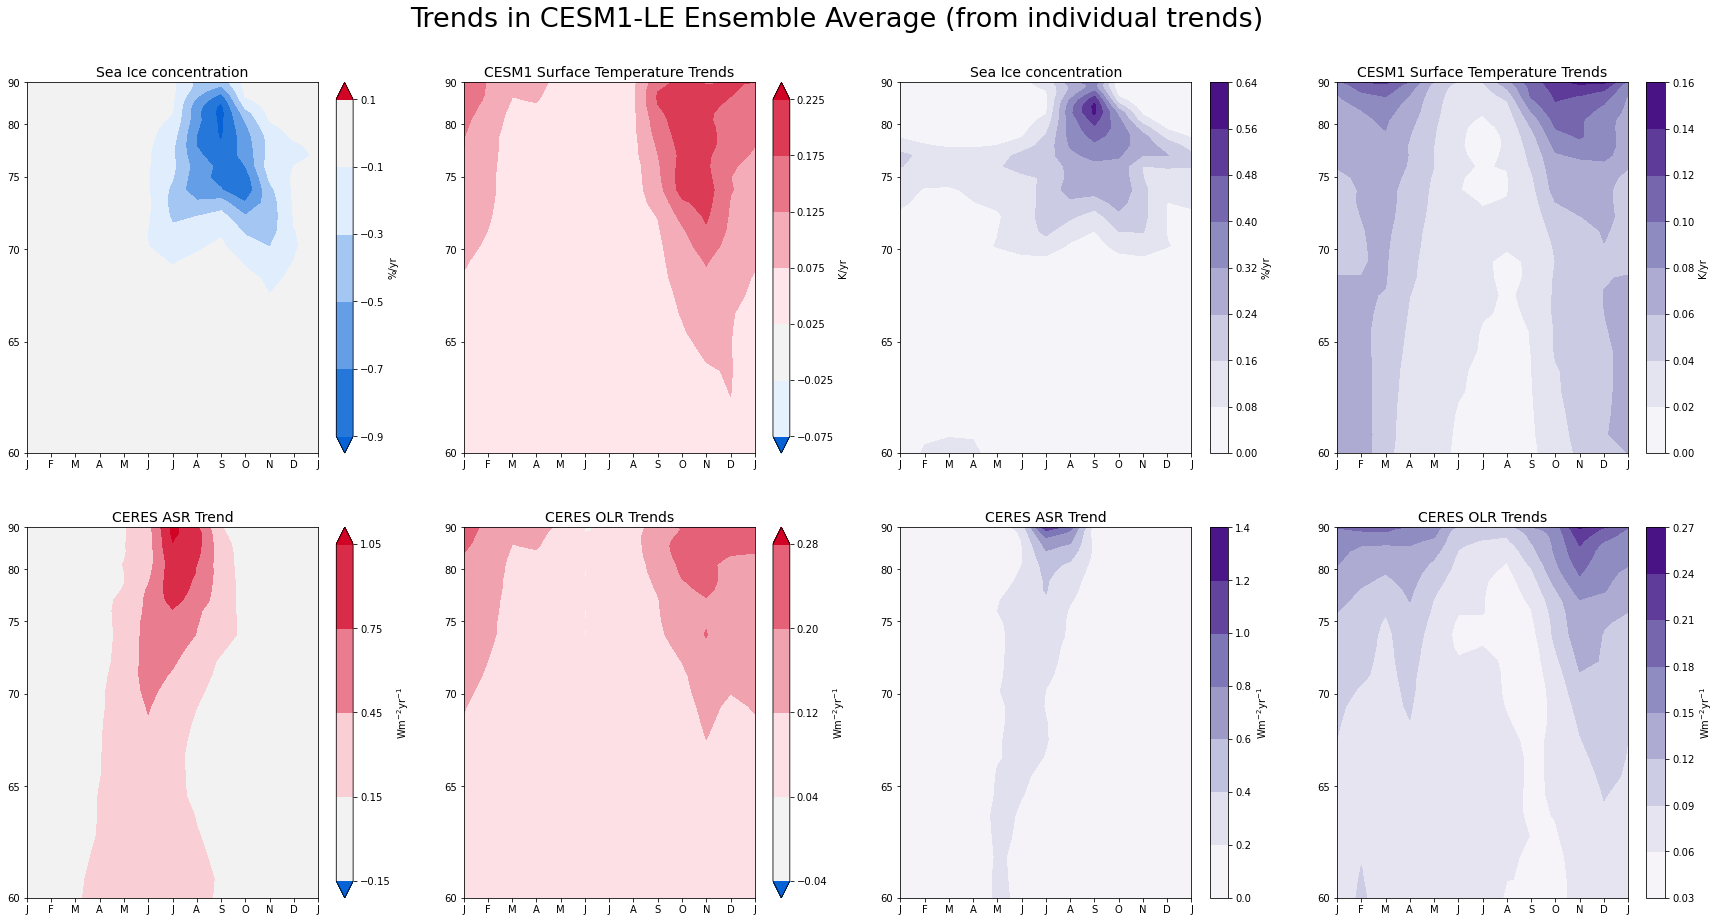

In [201]:
_olr2 = multiens_dict['FLUT'].mean(dim='ensn')
_asr2 = multiens_dict['FSNTOA'].mean(dim='ensn')
_icefrac2 = multiens_dict['ICEFRAC'].mean(dim='ensn')
_ts2 = multiens_dict['TS'].mean(dim='ensn')

_olr2std = multiens_dict['FLUT'].std(dim='ensn')
_asr2std = multiens_dict['FSNTOA'].std(dim='ensn')
_icefrac2std = multiens_dict['ICEFRAC'].std(dim='ensn')
_ts2std = multiens_dict['TS'].std(dim='ensn')

ts_trends_wrapped = xr.concat([_ts2['TREND'],_ts2['TREND'][0].assign_coords({'month':13})],dim='month')

seaice_trends_wrapped = xr.concat([_icefrac2['TREND'],_icefrac2['TREND'][0].assign_coords({'month':13})],dim='month')

asr_trends_wrapped = xr.concat([_asr2['TREND'],_asr2['TREND'][0].assign_coords({'month':13})],dim='month')

olr_trends_wrapped = xr.concat([_olr2['TREND'],_olr2['TREND'][0].assign_coords({'month':13})],dim='month')


ts_std_wrapped = xr.concat([_ts2std['TREND'],_ts2std['TREND'][0].assign_coords({'month':13})],dim='month')

seaice_std_wrapped = xr.concat([_icefrac2std['TREND'],_icefrac2std['TREND'][0].assign_coords({'month':13})],dim='month')

asr_std_wrapped = xr.concat([_asr2std['TREND'],_asr2std['TREND'][0].assign_coords({'month':13})],dim='month')

olr_std_wrapped = xr.concat([_olr2std['TREND'],_olr2std['TREND'][0].assign_coords({'month':13})],dim='month')

fig1,axs = plt.subplots(nrows=2,ncols=4,figsize=(30,15))

axes = axs.flat

ytick_labels = np.array([60,65,70,75,80,90])
yticks = np.sin(np.pi*ytick_labels/180)

xtick_labels = ['J','F','M','A','M','J','J','A','S','O','N','D','J']
xticks = np.arange(1,13.01,1)

palette = sns.diverging_palette(257, 10, s=99, l=44, sep=50, n=8, as_cmap=True)

# Set axis ticks accounting for area weighting
for _ax in axes:
    _ax.set_ylim(np.sin(np.pi/3),1)
    _ax.set_yticks(yticks)
    _ax.set_yticklabels(ytick_labels)
    _ax.set_xticks(xticks)
    _ax.set_xticklabels(xtick_labels)

lat_weighted0 = np.sin(np.pi/180*seaice_trends_wrapped['lat'])
im0 = axes[0].contourf(seaice_trends_wrapped['month'],lat_weighted0,seaice_trends_wrapped.transpose('lat','month'), # -1.4,0.4
                       cmap=palette,norm=mpl.colors.TwoSlopeNorm(vmin=-0.9, vcenter=0., vmax=0.9),levels=np.arange(-0.9,0.11,0.2),extend='both')
axes[0].set_title('Sea Ice concentration',fontsize=14)
plt.colorbar(im0,ax=axes[0],label='%/yr')

lat_weighted1 = np.sin(np.pi/180*ts_trends_wrapped['lat'])
im1 = axes[1].contourf(ts_trends_wrapped['month'],lat_weighted1,ts_trends_wrapped.transpose('lat','month'), # -0.15,0.45
                       cmap=palette,norm=mpl.colors.TwoSlopeNorm(vmin=-0.25, vcenter=0., vmax=0.25),levels=np.arange(-0.075,0.2251,0.05),extend='both')
axes[1].set_title('CESM1 Surface Temperature Trends',fontsize=14)
cbar = plt.colorbar(im1,ax=axes[1],label='K/yr')

lat_weighted4 = np.sin(np.pi/180*asr_trends_wrapped['lat'])
im2 = axes[4].contourf(asr_trends_wrapped['month'],lat_weighted4,asr_trends_wrapped.transpose('lat','month'), # -0.6,3.0
                       cmap=palette,norm=mpl.colors.TwoSlopeNorm(vmin=-1.05, vcenter=0., vmax=1.05),levels=np.arange(-0.15,1.06,0.30),extend='both')
axes[4].set_title('CERES ASR Trend',fontsize=14)
plt.colorbar(im2,ax=axes[4],label='Wm$^{-2}$yr$^{-1}$')

lat_weighted5 = np.sin(np.pi/180*olr_trends_wrapped['lat'])
im3 = axes[5].contourf(olr_trends_wrapped['month'],lat_weighted5,olr_trends_wrapped.transpose('lat','month'), # -0.3,0.7
                       cmap=palette,norm=mpl.colors.TwoSlopeNorm(vmin=-0.36, vcenter=0., vmax=0.36),levels=np.arange(-0.04,0.36,0.08),extend='both')
axes[5].set_title('CERES OLR Trends',fontsize=14)
plt.colorbar(im3,ax=axes[5],label='Wm$^{-2}$yr$^{-1}$')

lat_weighted2 = np.sin(np.pi/180*seaice_std_wrapped['lat'])
im2 = axes[2].contourf(seaice_std_wrapped['month'],lat_weighted2,seaice_std_wrapped.transpose('lat','month'), # -1.4,0.4
                       cmap='Purples')#,norm=mpl.colors.TwoSlopeNorm(vmin=-0.9, vcenter=0., vmax=0.9),levels=np.arange(-0.9,0.11,0.2),extend='both')
axes[2].set_title('Sea Ice concentration',fontsize=14)
plt.colorbar(im2,ax=axes[2],label='%/yr')

lat_weighted3 = np.sin(np.pi/180*ts_std_wrapped['lat'])
im3 = axes[3].contourf(ts_std_wrapped['month'],lat_weighted3,ts_std_wrapped.transpose('lat','month'), # -0.15,0.45
                       cmap='Purples')#,norm=mpl.colors.TwoSlopeNorm(vmin=-0.25, vcenter=0., vmax=0.25),levels=np.arange(-0.075,0.2251,0.05),extend='both')
axes[3].set_title('CESM1 Surface Temperature Trends',fontsize=14)
cbar = plt.colorbar(im3,ax=axes[3],label='K/yr')

lat_weighted6 = np.sin(np.pi/180*asr_std_wrapped['lat'])
im6 = axes[6].contourf(asr_std_wrapped['month'],lat_weighted6,asr_std_wrapped.transpose('lat','month'), # -0.6,3.0
                       cmap='Purples')#,norm=mpl.colors.TwoSlopeNorm(vmin=-1.05, vcenter=0., vmax=1.05),levels=np.arange(-0.15,1.06,0.30),extend='both')
axes[6].set_title('CERES ASR Trend',fontsize=14)
plt.colorbar(im6,ax=axes[6],label='Wm$^{-2}$yr$^{-1}$')

lat_weighted7 = np.sin(np.pi/180*olr_std_wrapped['lat'])
im7 = axes[7].contourf(olr_std_wrapped['month'],lat_weighted7,olr_std_wrapped.transpose('lat','month'), # -0.3,0.7
                       cmap='Purples')#,norm=mpl.colors.TwoSlopeNorm(vmin=-0.36, vcenter=0., vmax=0.36),levels=np.arange(-0.04,0.36,0.08),extend='both')
axes[7].set_title('CERES OLR Trends',fontsize=14)
plt.colorbar(im7,ax=axes[7],label='Wm$^{-2}$yr$^{-1}$')

fig1.suptitle('Trends in CESM1-LE Ensemble Average (from individual trends)',fontsize=27,y=0.95)